# 多类支持向量机练习

*完成并连同作业上交你完整的工作表(包括其输出及工作表外的任何支持代码),更多详情请参见课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

在这个练习中，你将:
    
- 为SVM实现一个全向量化的**损失函数**
- 实现其**解析梯度**的全向量化表达式
- 使用数值梯度**检查你的实现**
- 使用验证集**调整学习率和正则化**强度
- 用**SGD优化**损耗函数
- **可视化**最后学习的重量

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


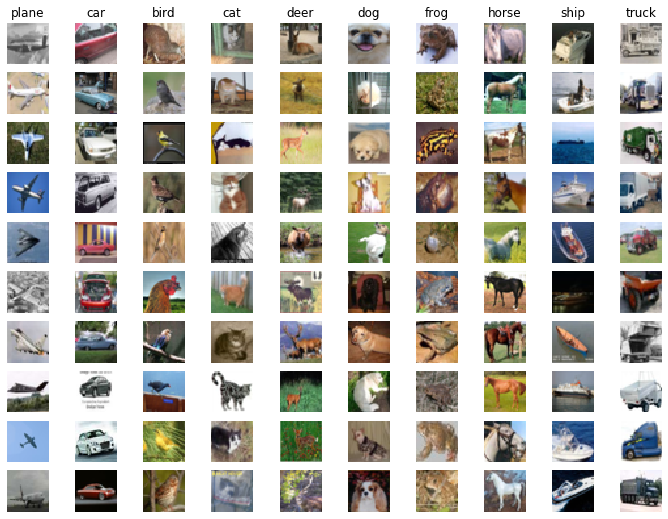

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347
 136.58542857 132.78293878 132.094      137.14008163 133.177
 132.76759184 137.77767347 133.70602041 133.29373469 138.21244898
 134.08095918 133.8194898  138.67242857 134.45065306 134.41440816
 139.20602041 134.94291837 134.85138776 139.55787755 135.22173469
 135.14859184 139.86202041 135.43195918 135.31191837 140.00128571
 135.5654898  135.52016327 140.17377551 135.71577551 135.54589796
 140.17855102 135.71587755 135.55465306 140.15055102 135.69661224
 135.52167347 140.08855102 135.63073469 135.4325102  140.00187755
 135.47902041 135.39046939 139.9555102  135.43814286 135.36910204
 139.93644898 135.44763265 135.25942857 139.84093878 135.34230612
 134.98636735 139.59830612 135.08753061 134.84430612 139.51479592
 135.07187755 134.69879592 139.39363265 134.9984898  134.41985714
 139.19859184 134.81940816 133.94426531 138.85381633 134.52361224
 133.49555102 1

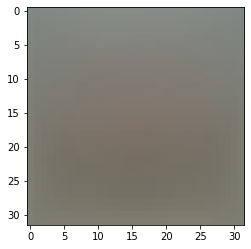

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print (mean_image[:100]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM 分类器

本节的代码将全部写在**cs231n/classifiers/ linear_svm .py**内

函数`svm_loss_naive`，使用for循环来评估多类SVM损失函数。

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print ('loss: %f' % (loss, ))

loss: 8.619065


从上面的函数返回的`grad`现在全部为零。推导并实现SVM损失函数的梯度，并将其在函数`svm_loss_naive`中实现

为了检查是否正确地实现了梯度，可以数值地估计损失函数的梯度，并将数值估计与计算的梯度进行比较

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -12.786243 analytic: -12.786243, relative error: 4.317440e-12
numerical: -32.275593 analytic: -32.275593, relative error: 5.962946e-12
numerical: -10.672298 analytic: -10.672298, relative error: 7.590834e-12
numerical: -6.073216 analytic: -6.073216, relative error: 5.375511e-11
numerical: -5.318307 analytic: -5.318307, relative error: 1.817321e-11
numerical: 1.306362 analytic: 1.306362, relative error: 4.206628e-10
numerical: -7.702849 analytic: -7.702849, relative error: 2.190533e-11
numerical: 37.113582 analytic: 37.113582, relative error: 8.373487e-12
numerical: 2.817729 analytic: 2.817729, relative error: 1.512354e-10
numerical: 3.295659 analytic: 3.295659, relative error: 4.225408e-11
numerical: 4.383649 analytic: 4.383649, relative error: 1.335819e-10
numerical: -19.555962 analytic: -19.555962, relative error: 1.657994e-11
numerical: -3.298629 analytic: -3.298629, relative error: 4.544705e-11
numerical: -1.023481 analytic: -1.023481, relative error: 8.189950e-11
numeri

### Inline Question 1:
这是有可能的，在一段时间的一个尺寸在gradcheck将不完全匹配。这种差异是由什么引起的呢?这是担忧的理由吗?在一维中，梯度检查可能失败的简单例子是什么? *提示:SVM损失函数严格来说不是可微的*

**Your Answer:** *fill this in.*

- 在某些点上SVM的损失函数是不可微的，如在零点上的ReLU是不可微的。


In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print ('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.619065e+00 computed in 0.152592s
Vectorized loss: 8.619065e+00 computed in 0.002996s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

Naive loss and gradient: computed in 0.124667s
Vectorized loss and gradient: computed in 0.004989s
difference: 0.000000


### 随机梯度下降
我们现在有了矢量化的有效的损失表达式，梯度和我们的梯度匹配的数值梯度。因此，我们准备做SGD以减少损失。

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=5000, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

iteration 0 / 5000: loss 798.692433
iteration 100 / 5000: loss 292.606398
iteration 200 / 5000: loss 109.549670
iteration 300 / 5000: loss 43.355177
iteration 400 / 5000: loss 18.959848
iteration 500 / 5000: loss 10.056210
iteration 600 / 5000: loss 6.924986
iteration 700 / 5000: loss 5.635385
iteration 800 / 5000: loss 5.600088
iteration 900 / 5000: loss 6.069034
iteration 1000 / 5000: loss 5.762943
iteration 1100 / 5000: loss 5.241382
iteration 1200 / 5000: loss 5.519624
iteration 1300 / 5000: loss 5.319294
iteration 1400 / 5000: loss 5.432656
iteration 1500 / 5000: loss 5.063352
iteration 1600 / 5000: loss 5.222987
iteration 1700 / 5000: loss 4.926634
iteration 1800 / 5000: loss 5.373097
iteration 1900 / 5000: loss 5.026955
iteration 2000 / 5000: loss 5.861126
iteration 2100 / 5000: loss 5.786459
iteration 2200 / 5000: loss 5.779969
iteration 2300 / 5000: loss 5.911354
iteration 2400 / 5000: loss 5.367954
iteration 2500 / 5000: loss 5.810034
iteration 2600 / 5000: loss 5.487169
iter

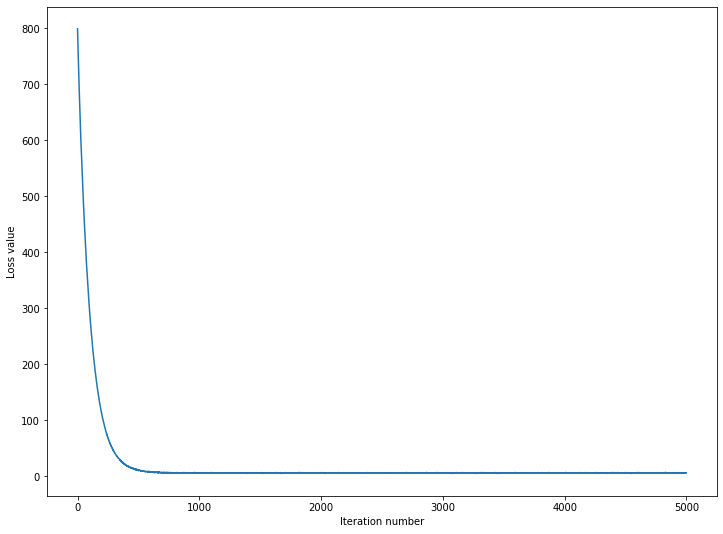

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365143
validation accuracy: 0.376000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=reg, num_iters=5000, verbose=True)
        y_train_pred = svm.predict(X_train)
        acc_tr = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(rate, reg)] = (acc_tr, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 803.425842
iteration 100 / 5000: loss 292.073306
iteration 200 / 5000: loss 109.687604
iteration 300 / 5000: loss 43.159855
iteration 400 / 5000: loss 19.001750
iteration 500 / 5000: loss 10.351725
iteration 600 / 5000: loss 7.174576
iteration 700 / 5000: loss 6.044697
iteration 800 / 5000: loss 5.879172
iteration 900 / 5000: loss 5.262640
iteration 1000 / 5000: loss 5.334857
iteration 1100 / 5000: loss 5.338515
iteration 1200 / 5000: loss 5.546114
iteration 1300 / 5000: loss 5.410655
iteration 1400 / 5000: loss 5.565541
iteration 1500 / 5000: loss 5.452913
iteration 1600 / 5000: loss 5.341955
iteration 1700 / 5000: loss 5.476097
iteration 1800 / 5000: loss 5.243475
iteration 1900 / 5000: loss 5.577067
iteration 2000 / 5000: loss 5.073577
iteration 2100 / 5000: loss 4.930222
iteration 2200 / 5000: loss 5.575246
iteration 2300 / 5000: loss 5.184887
iteration 2400 / 5000: loss 4.766914
iteration 2500 / 5000: loss 5.175192
iteration 2600 / 5000: loss 4.862667
iter

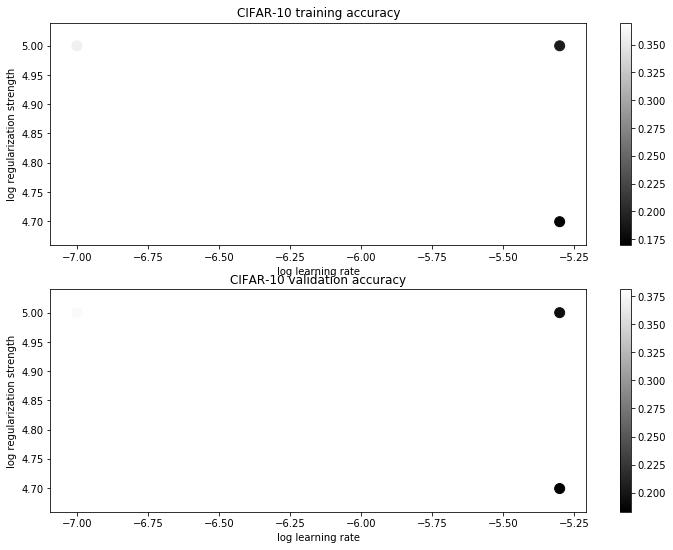

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.369000


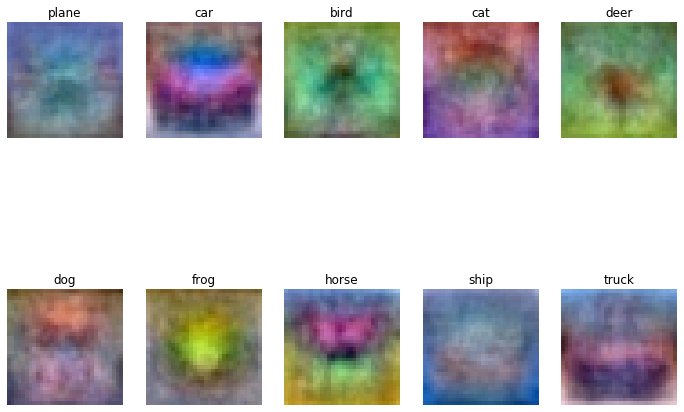

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

- 看不出什么鬼东西